In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from yahooquery import Ticker
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose

import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2
sns.set()

import scipy
import statsmodels.api as sm
import sklearn
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import warnings
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")

### Importing the Data for 15 tickers

In [2]:
tc = Ticker(['aapl', 'msft', '^spx', '^N225', '^ftse', 'goog', 'amzn', 'tsla', 'meta', 'nvda', 'jpm', 'gs', 'amd', 'nflx', 'ibm'])

In [3]:
tc_history = tc.history(start = '2018-01-01', end='2024-04-15')
df = tc_history.pivot_table(index='date', columns='symbol', values='adjclose')
df = df.reset_index(level=0)
df = df.rename(columns={'^N225': 'nikkei', '^ftse': 'ftse', '^spx': 'spx'})
df

symbol,date,nikkei,ftse,spx,aapl,amd,amzn,goog,gs,ibm,jpm,meta,msft,nflx,nvda,tsla
0,2018-01-02,NaN,7648.100098,2695.810059,40.670975,10.980000,59.450500,53.250000,222.359314,109.547691,89.602844,181.227707,80.080925,201.070007,49.310486,21.368668
1,2018-01-03,NaN,7671.100098,2713.060059,40.663895,11.550000,60.209999,54.124001,220.289383,112.558937,89.694160,184.474274,80.453598,205.050003,52.555782,21.150000
2,2018-01-04,23506.330078,7695.899902,2723.989990,40.852768,12.120000,60.479500,54.320000,223.368179,114.838654,90.979073,184.134628,81.161720,205.630005,52.832825,20.974667
3,2018-01-05,23714.529297,7724.200195,2743.149902,41.317905,11.880000,61.457001,55.111500,222.228867,115.399689,90.395012,186.651962,82.167961,209.990005,53.280544,21.105333
4,2018-01-08,NaN,7696.500000,2747.709961,41.164433,12.280000,62.343498,55.347000,219.002213,116.095673,90.528511,188.080444,82.251831,212.050003,54.913097,22.427334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630,2024-04-09,39773.128906,7934.799805,5209.910156,169.669998,170.779999,185.669998,158.139999,410.709991,189.309998,197.149994,516.900024,426.279999,618.200012,853.539978,176.880005
1631,2024-04-10,39581.808594,7961.200195,5160.640137,167.779999,167.139999,185.949997,157.660004,400.760010,186.039993,195.470001,519.830017,423.260010,618.580017,870.390015,171.759995
1632,2024-04-11,39442.628906,7923.799805,5199.060059,175.039993,170.500000,189.050003,160.789993,397.480011,185.899994,195.429993,523.159973,427.929993,628.780029,906.159973,174.600006
1633,2024-04-12,39523.550781,7995.600098,5123.410156,176.550003,163.279999,186.130005,159.190002,389.489990,182.270004,182.789993,511.899994,421.899994,622.830017,881.859985,171.050003


### Handling MIssing Values

In [4]:
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
df.isna().sum()

symbol
date      0
nikkei    0
ftse      0
spx       0
aapl      0
amd       0
amzn      0
goog      0
gs        0
ibm       0
jpm       0
meta      0
msft      0
nflx      0
nvda      0
tsla      0
dtype: int64

### Plotting one Ticker

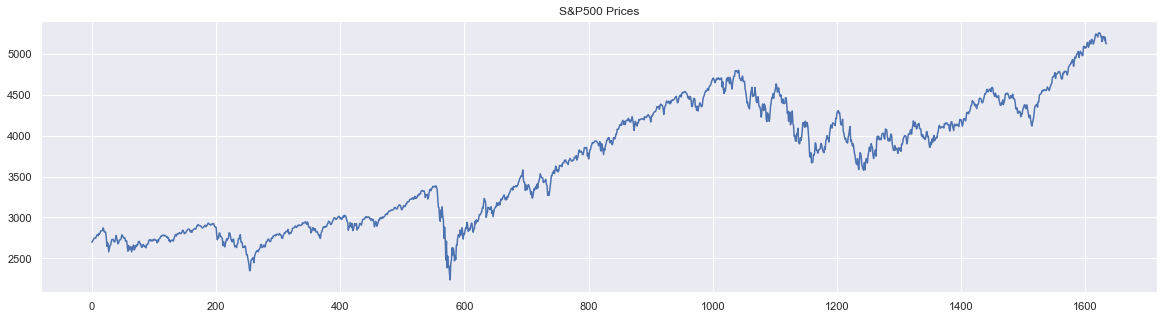

In [5]:
df.spx.plot(figsize=(20,5), title = "S&P500 Prices")
plt.show()

### From Text to Date

In [6]:
df.set_index("date", inplace=True)
df.head()

symbol,nikkei,ftse,spx,aapl,amd,amzn,goog,gs,ibm,jpm,meta,msft,nflx,nvda,tsla
date,,,,,,,,,,,,,,,
2018-01-02,23506.330078,7648.100098,2695.810059,40.670975,10.98,59.450500,53.250000,222.359314,109.547691,89.602844,181.227707,80.080925,201.070007,49.310486,21.368668
2018-01-03,23506.330078,7671.100098,2713.060059,40.663895,11.55,60.209999,54.124001,220.289383,112.558937,89.694160,184.474274,80.453598,205.050003,52.555782,21.150000
2018-01-04,23506.330078,7695.899902,2723.989990,40.852768,12.12,60.479500,54.320000,223.368179,114.838654,90.979073,184.134628,81.161720,205.630005,52.832825,20.974667
2018-01-05,23714.529297,7724.200195,2743.149902,41.317905,11.88,61.457001,55.111500,222.228867,115.399689,90.395012,186.651962,82.167961,209.990005,53.280544,21.105333
2018-01-08,23714.529297,7696.500000,2747.709961,41.164433,12.28,62.343498,55.347000,219.002213,116.095673,90.528511,188.080444,82.251831,212.050003,54.913097,22.427334


In [7]:
aapl =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'amzn', 'goog', 'gs', 'ibm', 'jpm', 'msft', 'nflx', 'nvda', 'tsla', 'meta'])
nikkei =  df.drop(columns=['ftse', 'spx', 'amd', 'amzn', 'goog', 'gs', 'ibm', 'jpm', 'msft', 'nflx', 'nvda', 'tsla', 'meta', 'aapl'])
ftse =  df.drop(columns=['nikkei','spx', 'amd', 'amzn', 'goog', 'gs', 'ibm', 'jpm', 'msft', 'nflx', 'nvda', 'tsla', 'meta', 'aapl'])
spx =  df.drop(columns=['nikkei', 'ftse',  'amd', 'amzn', 'goog', 'gs', 'ibm', 'jpm', 'msft', 'nflx', 'nvda', 'tsla', 'meta', 'aapl'])
amd =  df.drop(columns=['nikkei', 'ftse', 'spx','amzn', 'goog', 'gs', 'ibm', 'jpm', 'msft', 'nflx', 'nvda', 'tsla', 'meta', 'aapl'])
amzn =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'goog', 'gs', 'ibm', 'jpm', 'msft', 'nflx', 'nvda', 'tsla', 'meta', 'aapl'])
goog =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'amzn','gs', 'ibm', 'jpm', 'msft', 'nflx', 'nvda', 'tsla', 'meta', 'aapl'])
gs =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'amzn', 'goog','ibm', 'jpm', 'msft', 'nflx', 'nvda', 'tsla', 'meta', 'aapl'])
ibm =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'amzn', 'goog', 'gs',  'jpm', 'msft', 'nflx', 'nvda', 'tsla', 'meta', 'aapl'])
jpm =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'amzn', 'goog', 'gs', 'ibm',  'msft', 'nflx', 'nvda', 'tsla', 'meta', 'aapl'])
msft =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'amzn', 'goog', 'gs', 'ibm', 'jpm', 'nflx', 'nvda', 'tsla', 'meta', 'aapl'])
nflx =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'amzn', 'goog', 'gs', 'ibm', 'jpm', 'msft', 'nvda', 'tsla', 'meta', 'aapl'])
nvda =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'amzn', 'goog', 'gs', 'ibm', 'jpm', 'msft', 'nflx',  'tsla', 'meta', 'aapl'])
tsla =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'amzn', 'goog', 'gs', 'ibm', 'jpm', 'msft', 'nflx', 'nvda',  'meta', 'aapl'])
meta =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'amzn', 'goog', 'gs', 'ibm', 'jpm', 'msft', 'nflx', 'nvda', 'tsla', 'aapl'])


## Best models

In [8]:
df_comp = df.copy()

In [9]:
df_comp=df_comp.asfreq('d')

In [10]:
df_comp= df_comp.fillna(method = "ffill")

In [11]:
df_comp = df_comp.iloc[1:]

In [12]:
df_comp["ret_spx"] = df_comp.spx.pct_change(1).mul(100)
df_comp["ret_aapl"] = df_comp.aapl.pct_change(1).mul(100)
df_comp["ret_nikkei"] = df_comp.nikkei.pct_change(1).mul(100)
df_comp["ret_ftse"] = df_comp.ftse.pct_change(1).mul(100)
df_comp["ret_amd"] = df_comp.amd.pct_change(1).mul(100)
df_comp["ret_amzn"] = df_comp.amzn.pct_change(1).mul(100)
df_comp["ret_goog"] = df_comp.goog.pct_change(1).mul(100)
df_comp = df_comp.iloc[1:]

In [13]:
size = int(len(df_comp)*0.8)
df_train, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [14]:
df_test

symbol,nikkei,ftse,spx,aapl,amd,amzn,goog,gs,ibm,jpm,...,nflx,nvda,tsla,ret_spx,ret_aapl,ret_nikkei,ret_ftse,ret_amd,ret_amzn,ret_goog
date,,,,,,,,,,,,,,,,,,,,,
2023-01-13,26119.519531,7844.100098,3999.090088,133.840149,71.000000,98.120003,92.800003,359.959778,137.731506,138.232590,...,332.820007,168.907135,122.400002,0.399686,1.011898,-1.248783,0.642803,0.282482,2.991504,0.968338
2023-01-14,26119.519531,7844.100098,3999.090088,133.840149,71.000000,98.120003,92.800003,359.959778,137.731506,138.232590,...,332.820007,168.907135,122.400002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-01-15,26119.519531,7844.100098,3999.090088,133.840149,71.000000,98.120003,92.800003,359.959778,137.731506,138.232590,...,332.820007,168.907135,122.400002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-01-16,25822.320312,7860.100098,3999.090088,133.840149,71.000000,98.120003,92.800003,359.959778,137.731506,138.232590,...,332.820007,168.907135,122.400002,0.000000,0.000000,-1.137843,0.203975,0.000000,0.000000,0.000000
2023-01-17,26138.679688,7851.000000,3990.969971,135.012085,71.589996,96.050003,92.160004,336.783813,137.070633,136.096420,...,326.220001,176.933182,131.490005,-0.203049,0.875624,1.225139,-0.115776,0.830981,-2.109661,-0.689654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-11,39442.628906,7923.799805,5199.060059,175.039993,170.500000,189.050003,160.789993,397.480011,185.899994,195.429993,...,628.780029,906.159973,174.600006,0.744480,4.327092,-0.351625,-0.469783,2.010291,1.667118,1.985278
2024-04-12,39523.550781,7995.600098,5123.410156,176.550003,163.279999,186.130005,159.190002,389.489990,182.270004,182.789993,...,622.830017,881.859985,171.050003,-1.455069,0.862666,0.205163,0.906135,-4.234605,-1.544564,-0.995081
2024-04-13,39523.550781,7995.600098,5123.410156,176.550003,163.279999,186.130005,159.190002,389.489990,182.270004,182.789993,...,622.830017,881.859985,171.050003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [15]:
df_train.tail()

symbol,nikkei,ftse,spx,aapl,amd,amzn,goog,gs,ibm,jpm,...,nflx,nvda,tsla,ret_spx,ret_aapl,ret_nikkei,ret_ftse,ret_amd,ret_amzn,ret_goog
date,,,,,,,,,,,,,,,,,,,,,
2023-01-08,25973.849609,7699.500000,3895.080078,128.735245,63.959999,86.080002,88.160004,335.012848,135.663971,133.331970,...,315.549988,148.517136,113.059998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-01-09,25973.849609,7724.899902,3892.090088,129.261612,67.239998,87.360001,88.800003,339.748108,135.522369,132.781006,...,315.170013,156.203369,119.769997,-0.076763,0.408876,0.000000,0.329890,5.128203,1.486987,0.725952
2023-01-10,26175.560547,7694.500000,3919.250000,129.837662,68.050003,89.870003,89.239998,343.944489,136.702454,133.969925,...,327.540009,159.011978,118.849998,0.697823,0.445646,0.776592,-0.393531,1.204648,2.873171,0.495490
2023-01-11,26446.000000,7725.000000,3969.610107,132.578827,69.059998,95.089996,92.260002,350.797211,137.136719,134.965500,...,327.260010,159.931519,123.220001,1.284942,2.111225,1.033175,0.396387,1.484195,5.808383,3.384138
2023-01-12,26449.820312,7794.000000,3983.169922,132.499390,70.800003,95.269997,91.910004,356.052246,137.410507,134.830185,...,330.130005,165.029053,123.559998,0.341591,-0.059917,0.014446,0.893204,2.519556,0.189295,-0.379361


Fitting AR, MA & ARMA models

In [16]:
start_date = "2024-04-08"
end_date = "2024-04-15"

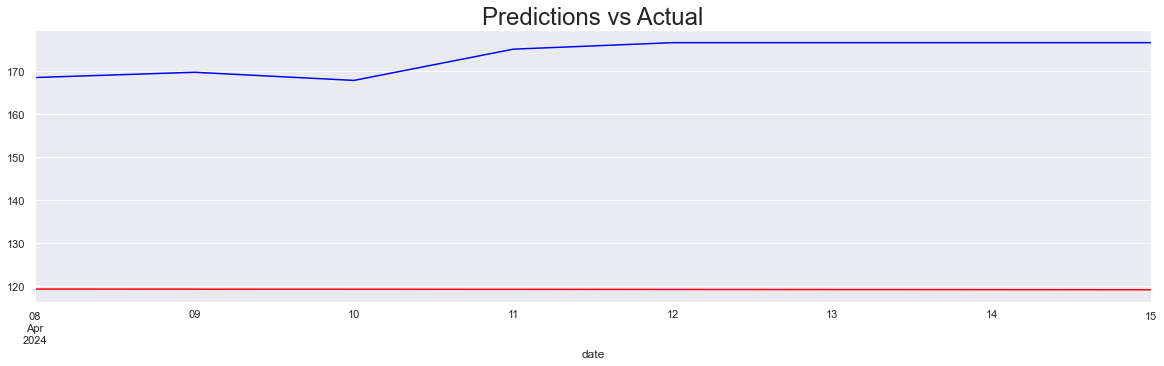

In [17]:
from statsmodels.tsa.arima.model import ARIMA 
model_ar = ARIMA(df_train.aapl, order = (1,0,0))
results_ar = model_ar.fit()

df_pred = results_ar.predict(start =start_date, end = end_date)

df_pred[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.aapl[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual", size = 24)
plt.show()

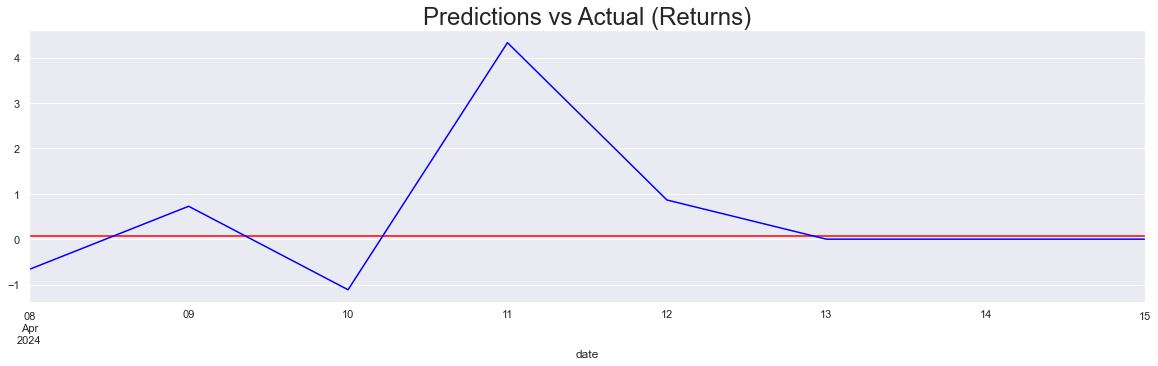

In [18]:
model_ret_ar = ARIMA(df_train.ret_aapl, order = (1,0,0))
results_ret_ar = model_ret_ar.fit()
df_pred_ar = results_ret_ar.predict(start =start_date, end = end_date)

df_pred_ar[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_aapl[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

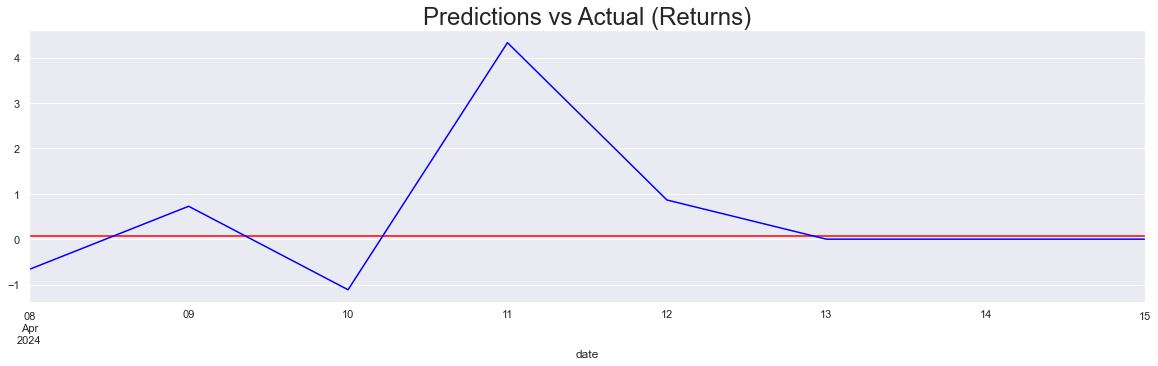

2.6335685175679826


In [19]:
model_ret_ar_9 = ARIMA(df_train.ret_aapl, order = (9,0,0))
results_ret_ar_9 = model_ret_ar_9.fit()
df_pred_ar_9 = results_ret_ar_9.predict(start =start_date, end = end_date)

df_pred_ar_9[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_aapl[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()


model_ret_ar_9 = mean_squared_error(df_pred_ar_9[start_date:end_date],df_test.ret_aapl[start_date:end_date])
print(model_ret_ar_9)

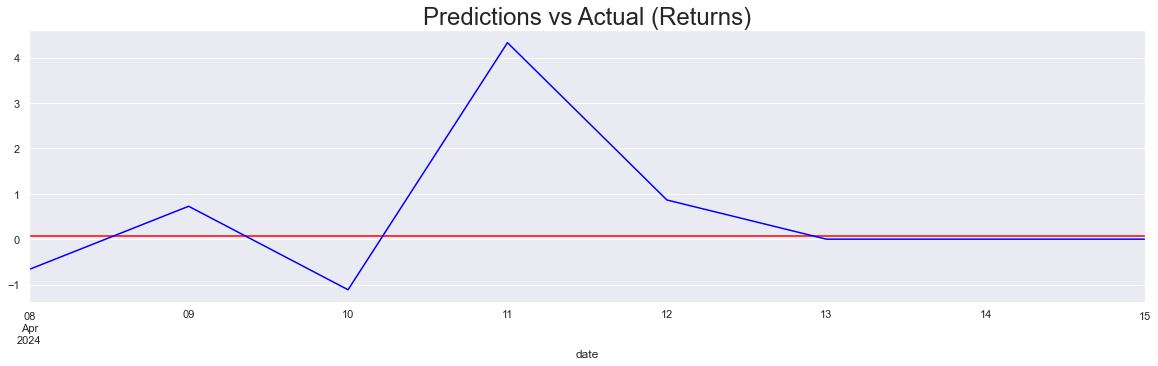

2.6335804049904796


In [20]:
model_ret_ma_9 = ARIMA(df_train.ret_aapl, order = (0,0,9))
results_ret_ma_9 = model_ret_ma_9.fit()
df_pred_ma_9 = results_ret_ma_9.predict(start =start_date, end = end_date)

df_pred_ma_9[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_aapl[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

model_ret_ma_9 = mean_squared_error(df_pred_ma_9[start_date:end_date],df_test.ret_aapl[start_date:end_date])
print(model_ret_ma_9)

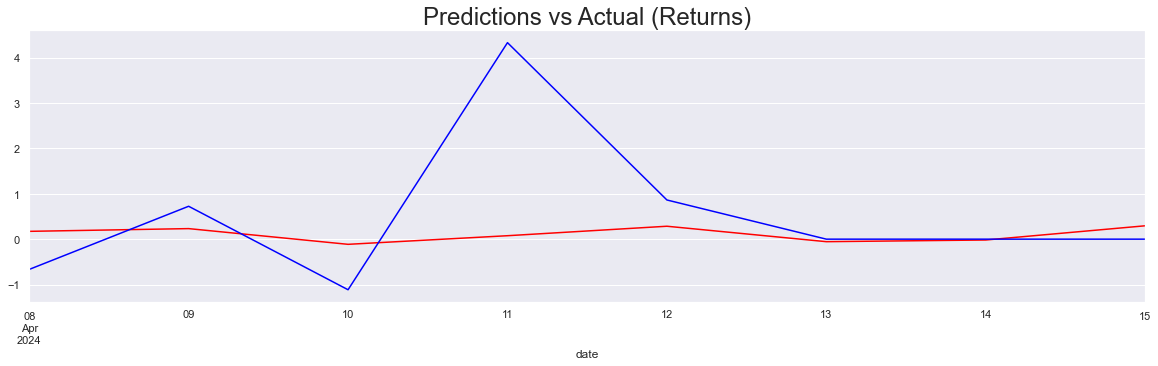

2.5552697698619644


In [21]:
end_date = "2024-04-15"
model_ret_ar_4_ma_4 = ARIMA(df_train.ret_aapl, order = (4,0,4))
results_ret_ar_4_ma_4 = model_ret_ar_4_ma_4.fit()
df_pred_ar_4_ma_4 = results_ret_ar_4_ma_4.predict(start =start_date, end = end_date)

df_pred_ar_4_ma_4[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_aapl[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

model_ret_ar_4_ma_4 = mean_squared_error(df_pred_ar_4_ma_4[start_date:end_date],df_test.ret_aapl[start_date:end_date])
print(model_ret_ar_4_ma_4)

In [22]:
df_pred_ar_4_ma_4.head()

2024-04-08    0.172125
2024-04-09    0.232218
2024-04-10   -0.113757
2024-04-11    0.075932
2024-04-12    0.284549
Freq: D, Name: predicted_mean, dtype: float64

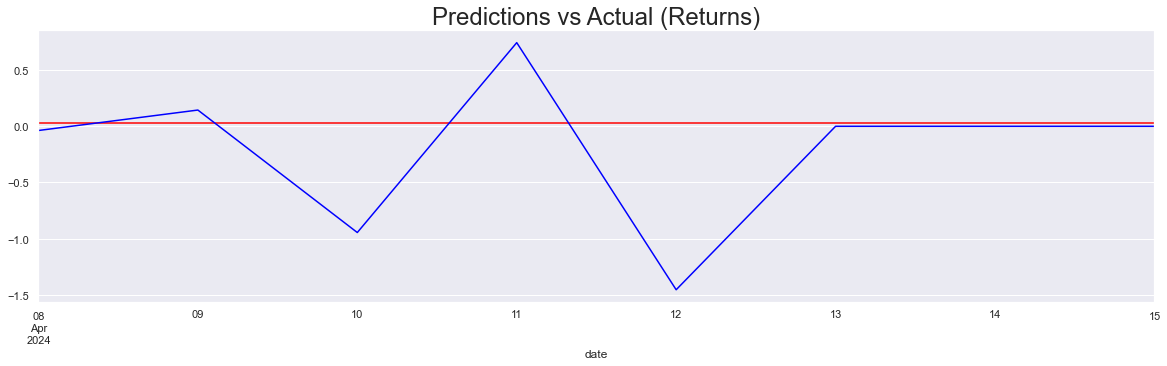

0.4598779820370691


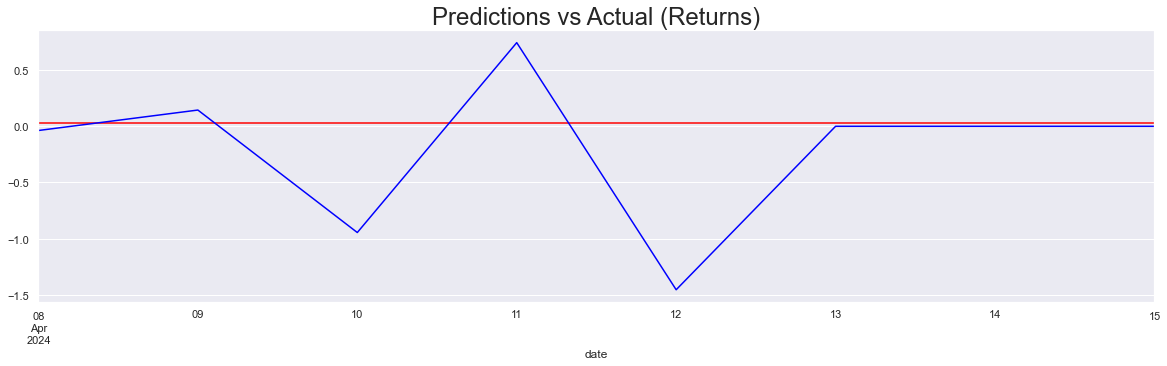

0.4598624147874659


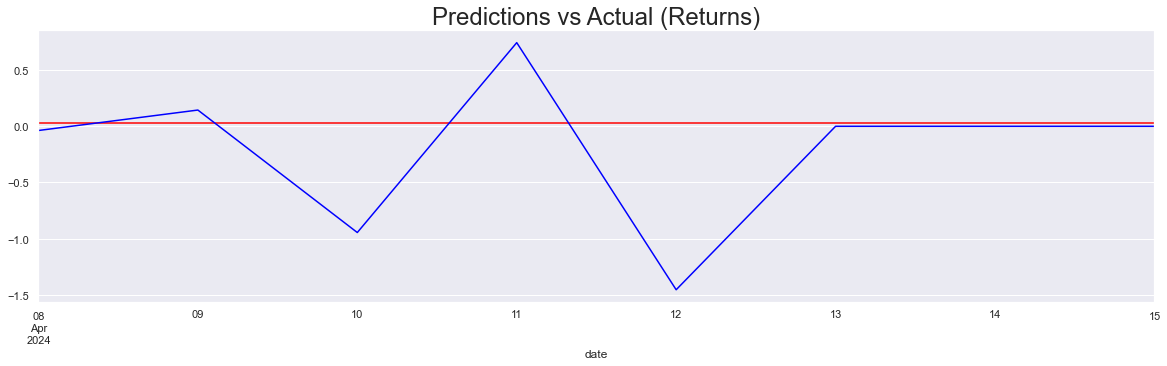

0.46000895555225396


In [23]:
#AR
model_ret_ar_9 = ARIMA(df_train.ret_spx, order = (9,0,0))
results_ret_ar_9 = model_ret_ar_9.fit()
df_pred_ar_9 = results_ret_ar_9.predict(start =start_date, end = end_date)

df_pred_ar_9[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_spx[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()


model_ret_ar_9 = mean_squared_error(df_pred_ar_9[start_date:end_date],df_test.ret_spx[start_date:end_date])
print(model_ret_ar_9)
# MA
model_ret_ma_9 = ARIMA(df_train.ret_spx, order = (0,0,9))
results_ret_ma_9 = model_ret_ma_9.fit()
df_pred_ma_9 = results_ret_ma_9.predict(start =start_date, end = end_date)

df_pred_ma_9[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_spx[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

model_ret_ma_9 = mean_squared_error(df_pred_ma_9[start_date:end_date],df_test.ret_spx[start_date:end_date])
print(model_ret_ma_9)
#ARMA
model_ret_ar_3_ma_3 = ARIMA(df_train.ret_spx, order = (3,0,3))
results_ret_ar_3_ma_3 = model_ret_ar_3_ma_3.fit()
df_pred_ar_3_ma_3 = results_ret_ar_3_ma_3.predict(start =start_date, end = end_date)

df_pred_ar_3_ma_3[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_spx[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

model_ret_ar_3_ma_3 = mean_squared_error(df_pred_ar_3_ma_3[start_date:end_date],df_test.ret_spx[start_date:end_date])
print(model_ret_ar_3_ma_3)

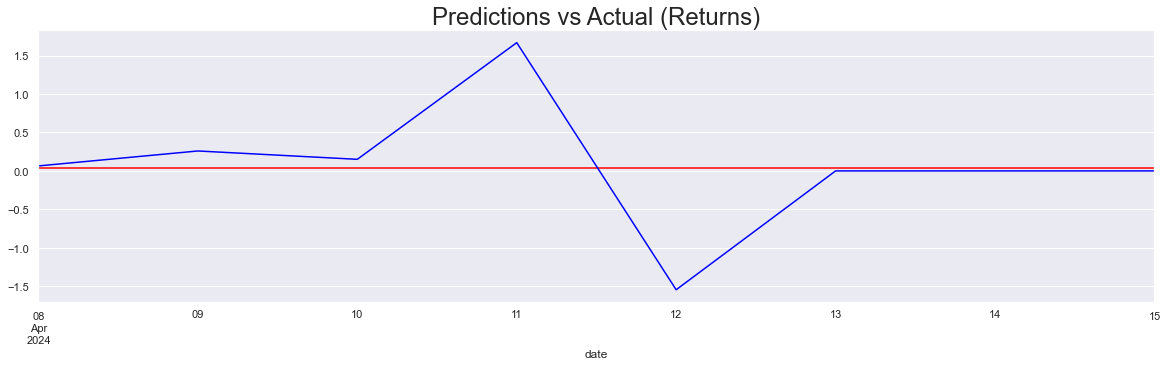

0.6528279919537052


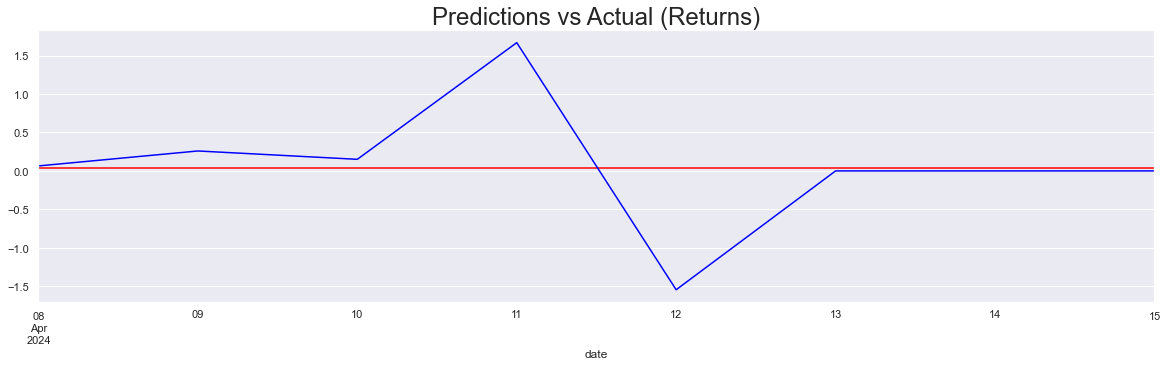

0.652827506385584


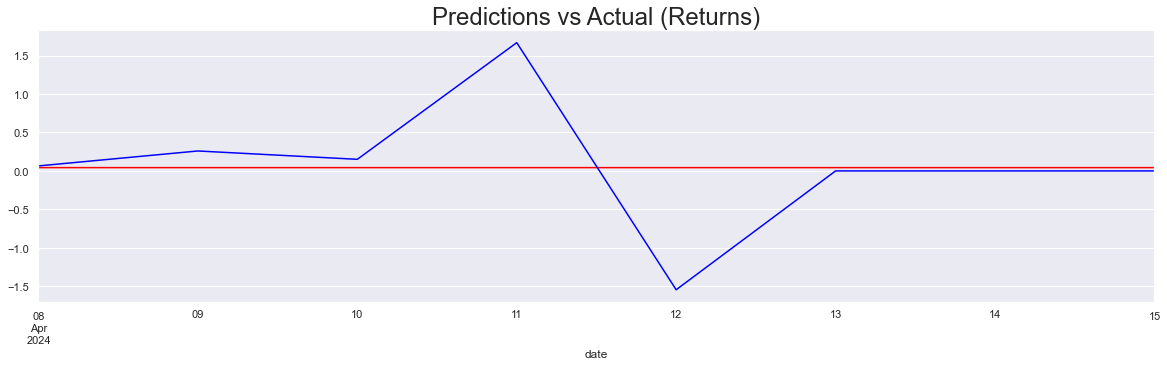

0.6528279896443847
0.652827506385584


In [24]:
#AR
model_ret_ar_8 = ARIMA(df_train.ret_amzn, order = (8,0,0))
results_ret_ar_8 = model_ret_ar_8.fit()
df_pred_ar_8 = results_ret_ar_8.predict(start =start_date, end = end_date)

df_pred_ar_8[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_amzn[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()


model_ret_ar_8 = mean_squared_error(df_pred_ar_8[start_date:end_date],df_test.ret_amzn[start_date:end_date])
print(model_ret_ar_8)
# MA
model_ret_ma_8 = ARIMA(df_train.ret_amzn, order = (0,0,8))
results_ret_ma_8 = model_ret_ma_8.fit()
df_pred_ma_8 = results_ret_ma_8.predict(start =start_date, end = end_date)

df_pred_ma_8[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_amzn[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

model_ret_ma_8 = mean_squared_error(df_pred_ma_8[start_date:end_date],df_test.ret_amzn[start_date:end_date])
print(model_ret_ma_8)
#ARMA
model_ret_ar_2_ma_2 = ARIMA(df_train.ret_amzn, order = (2,0,2))
results_ret_ar_2_ma_2 = model_ret_ar_2_ma_2.fit()
df_pred_ar_2_ma_2 = results_ret_ar_2_ma_2.predict(start =start_date, end = end_date)

df_pred_ar_2_ma_2[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_amzn[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

model_ret_ar_2_ma_2 = mean_squared_error(df_pred_ar_2_ma_2[start_date:end_date],df_test.ret_amzn[start_date:end_date])
print(model_ret_ar_2_ma_2)

print(min(model_ret_ar_8, 
model_ret_ma_8,model_ret_ar_2_ma_2 ))

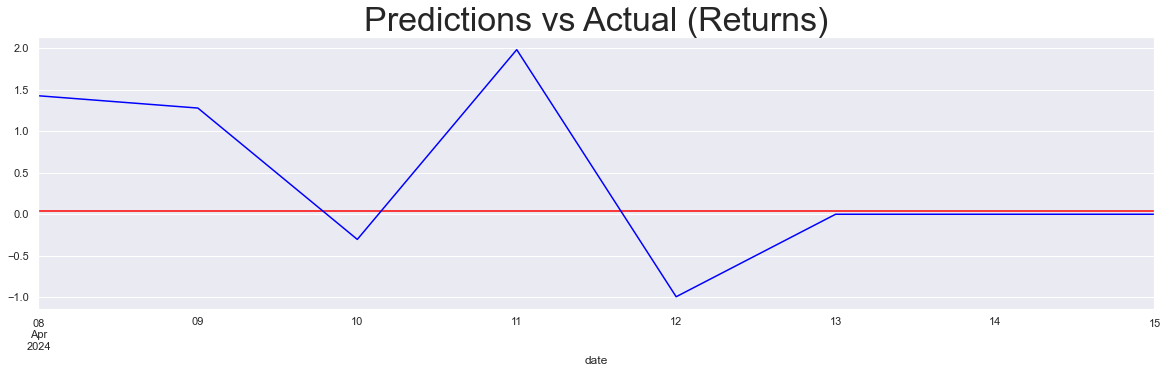

1.0544611878867842


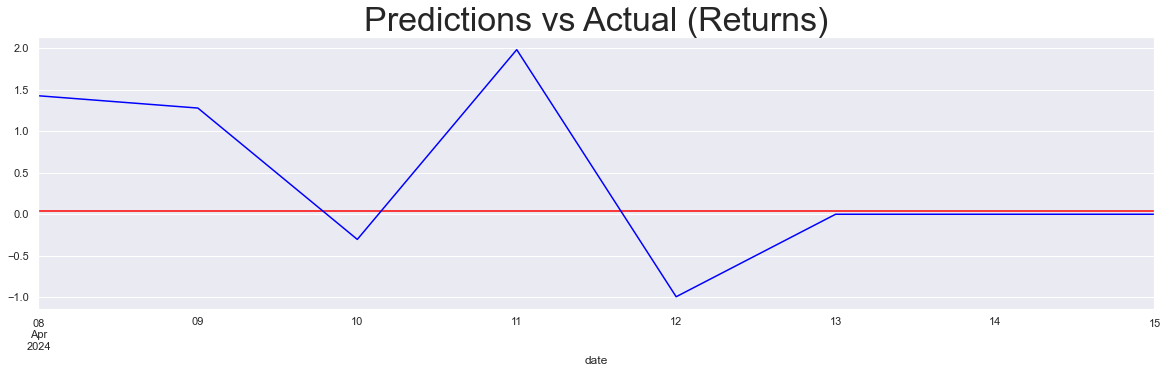

1.0545299916116844


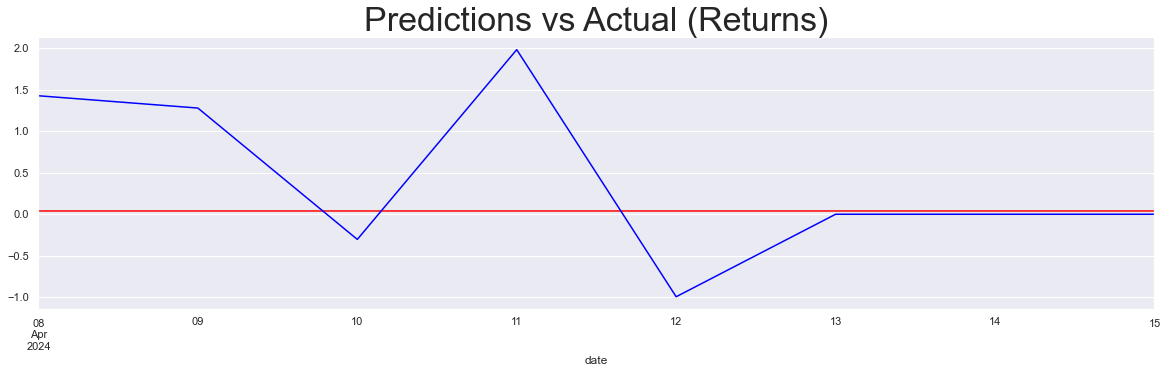

1.0563415481654286
1.0544611878867842


In [25]:
#AR
model_ret_ar_9 = ARIMA(df_train.ret_goog, order = (9,0,0))
results_ret_ar_9 = model_ret_ar_9.fit()
df_pred_ar_9 = results_ret_ar_9.predict(start =start_date, end = end_date)

df_pred_ar_9[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_goog[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 34)
plt.show()


model_ret_ar_9 = mean_squared_error(df_pred_ar_9[start_date:end_date],df_test.ret_goog[start_date:end_date])
print(model_ret_ar_9)
# MA
model_ret_ma_9 = ARIMA(df_train.ret_goog, order = (0,0,9))
results_ret_ma_9 = model_ret_ma_9.fit()
df_pred_ma_9 = results_ret_ma_9.predict(start =start_date, end = end_date)

df_pred_ma_9[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_goog[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 34)
plt.show()

model_ret_ma_9 = mean_squared_error(df_pred_ma_9[start_date:end_date],df_test.ret_goog[start_date:end_date])
print(model_ret_ma_9)
#ARMA
model_ret_ar_3_ma_3 = ARIMA(df_train.ret_goog, order = (3,0,3))
results_ret_ar_3_ma_3 = model_ret_ar_3_ma_3.fit()
df_pred_ar_3_ma_3 = results_ret_ar_3_ma_3.predict(start =start_date, end = end_date)

df_pred_ar_3_ma_3[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_goog[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 34)
plt.show()

model_ret_ar_3_ma_3 = mean_squared_error(df_pred_ar_3_ma_3[start_date:end_date],df_test.ret_goog[start_date:end_date])
print(model_ret_ar_3_ma_3)

print(min(model_ret_ar_9, 
model_ret_ma_9,model_ret_ar_3_ma_3 ))

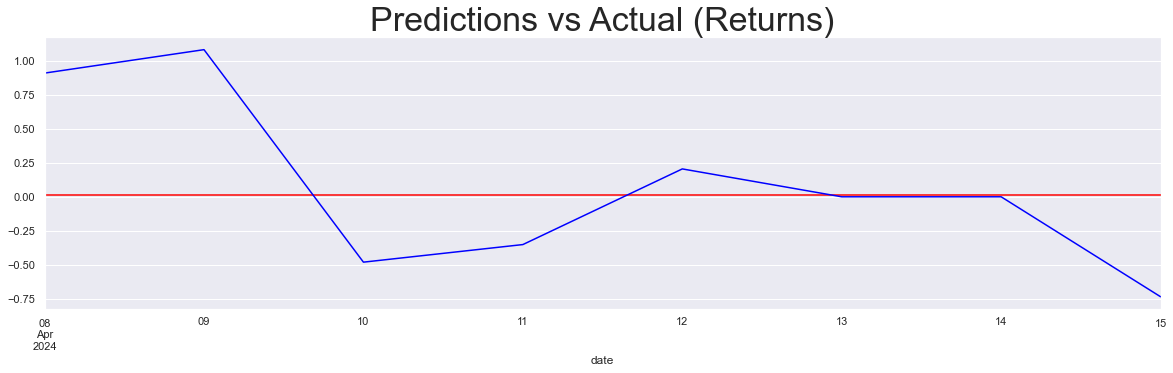

0.36575247259303867


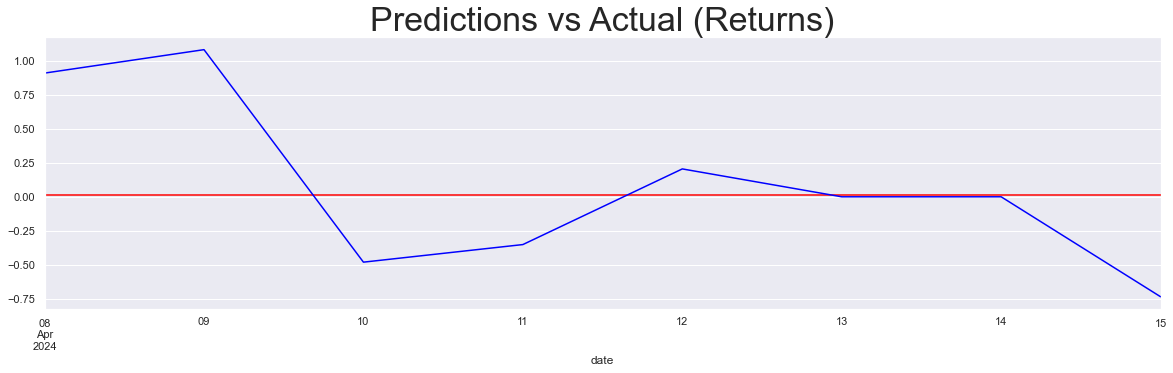

0.3657522277040457


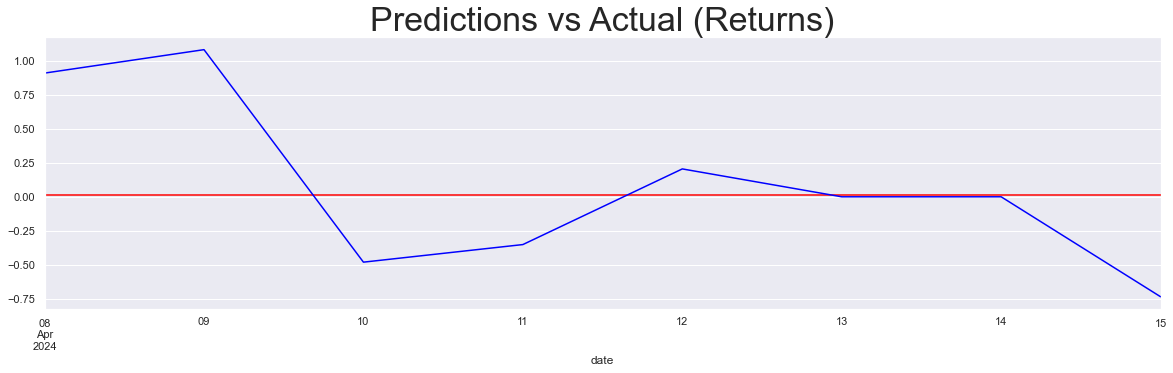

0.36574336860622375
0.36574336860622375


In [26]:
#AR
model_ret_ar_2 = ARIMA(df_train.ret_nikkei, order = (2,0,0))
results_ret_ar_2 = model_ret_ar_2.fit()
df_pred_ar_2 = results_ret_ar_2.predict(start =start_date, end = end_date)

df_pred_ar_2[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_nikkei[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 34)
plt.show()


model_ret_ar_2 = mean_squared_error(df_pred_ar_2[start_date:end_date],df_test.ret_nikkei[start_date:end_date])
print(model_ret_ar_2)
# MA
model_ret_ma_2 = ARIMA(df_train.ret_nikkei, order = (0,0,2))
results_ret_ma_2 = model_ret_ma_2.fit()
df_pred_ma_2 = results_ret_ma_2.predict(start =start_date, end = end_date)

df_pred_ma_2[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_nikkei[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 34)
plt.show()

model_ret_ma_2 = mean_squared_error(df_pred_ma_2[start_date:end_date],df_test.ret_nikkei[start_date:end_date])
print(model_ret_ma_2)
#ARMA
model_ret_ar_4_ma_4 = ARIMA(df_train.ret_nikkei, order = (4,0,4))
results_ret_ar_4_ma_4 = model_ret_ar_4_ma_4.fit()
df_pred_ar_4_ma_4 = results_ret_ar_4_ma_4.predict(start =start_date, end = end_date)

df_pred_ar_4_ma_4[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_nikkei[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 34)
plt.show()

model_ret_ar_4_ma_4 = mean_squared_error(df_pred_ar_4_ma_4[start_date:end_date],df_test.ret_nikkei[start_date:end_date])
print(model_ret_ar_4_ma_4)

print(min(model_ret_ar_2, 
model_ret_ma_2,model_ret_ar_4_ma_4 ))

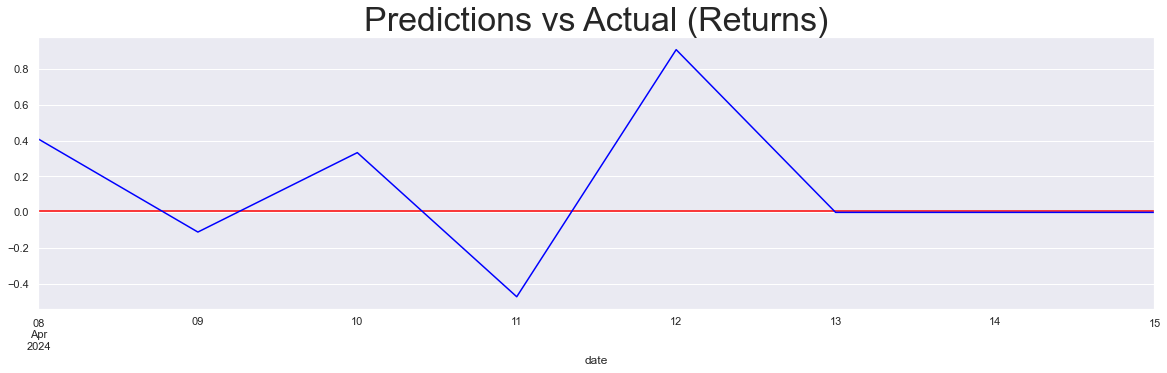

0.1650602852496563


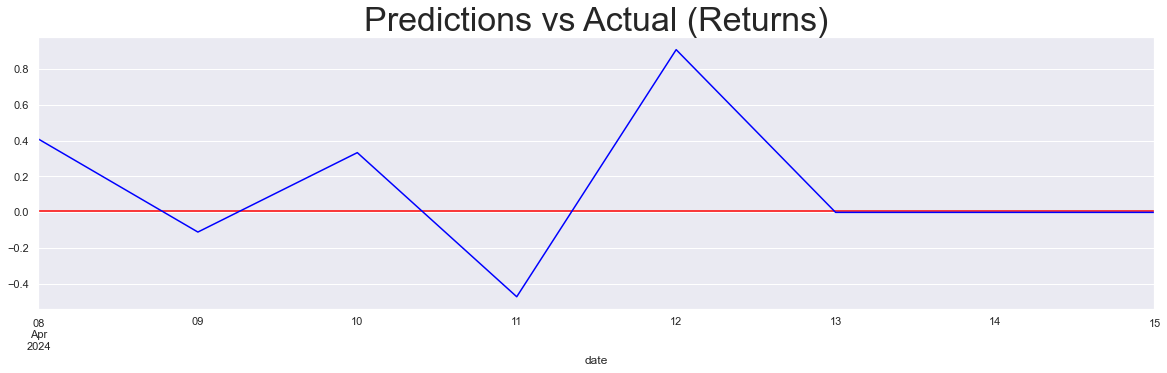

0.1650295931440095


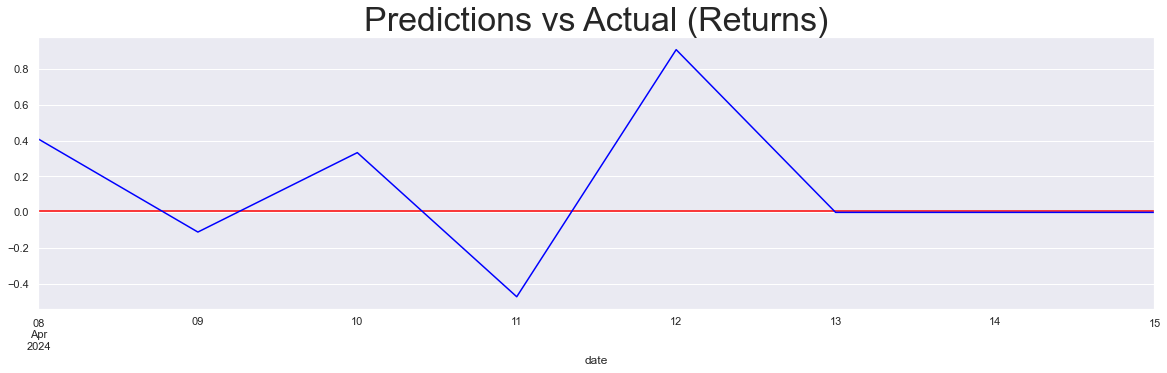

0.1649017276203135
0.1649017276203135


In [27]:
#AR
model_ret_ar_8 = ARIMA(df_train.ret_ftse, order = (8,0,0))
results_ret_ar_8 = model_ret_ar_8.fit()
df_pred_ar_8 = results_ret_ar_8.predict(start =start_date, end = end_date)

df_pred_ar_8[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_ftse[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 34)
plt.show()


model_ret_ar_8 = mean_squared_error(df_pred_ar_8[start_date:end_date],df_test.ret_ftse[start_date:end_date])
print(model_ret_ar_8)
# MA
model_ret_ma_9 = ARIMA(df_train.ret_ftse, order = (0,0,9))
results_ret_ma_9 = model_ret_ma_9.fit()
df_pred_ma_9 = results_ret_ma_9.predict(start =start_date, end = end_date)

df_pred_ma_9[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_ftse[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 34)
plt.show()

model_ret_ma_9 = mean_squared_error(df_pred_ma_9[start_date:end_date],df_test.ret_ftse[start_date:end_date])
print(model_ret_ma_9)
#ARMA
model_ret_ar_4_ma_4 = ARIMA(df_train.ret_ftse, order = (4,0,4))
results_ret_ar_4_ma_4 = model_ret_ar_4_ma_4.fit()
df_pred_ar_4_ma_4 = results_ret_ar_4_ma_4.predict(start =start_date, end = end_date)

df_pred_ar_4_ma_4[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_ftse[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 34)
plt.show()

model_ret_ar_4_ma_4 = mean_squared_error(df_pred_ar_4_ma_4[start_date:end_date],df_test.ret_ftse[start_date:end_date])
print(model_ret_ar_4_ma_4)

print(min(model_ret_ar_8, 
model_ret_ma_9,model_ret_ar_4_ma_4 ))

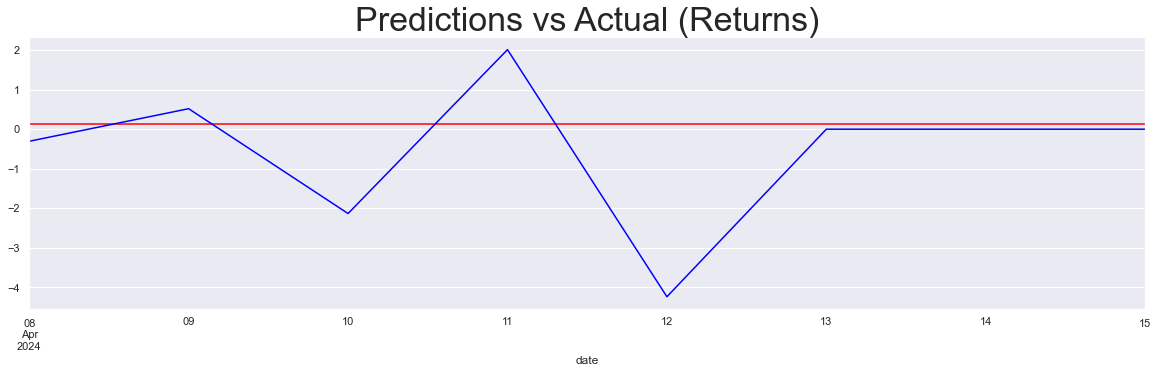

3.527596708458151


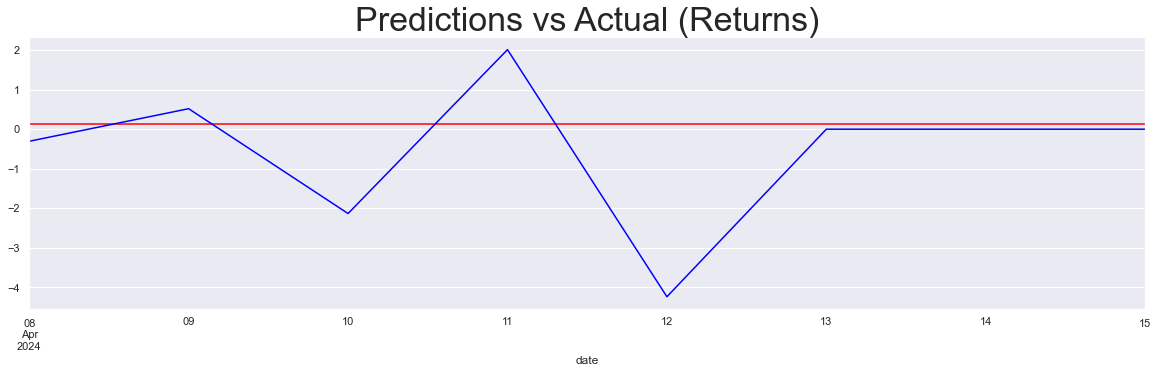

3.5274316012851434


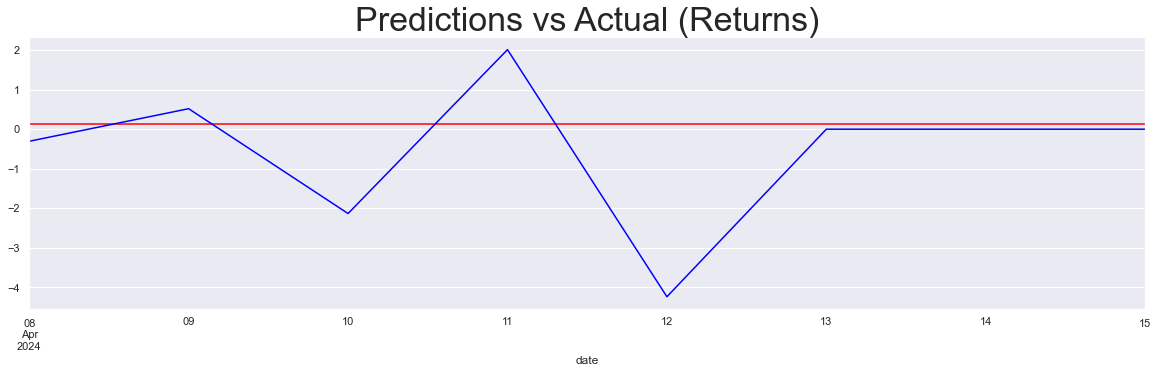

3.5274229535843324
3.5274229535843324


In [29]:
#AR
model_ret_ar_3 = ARIMA(df_train.ret_amd, order = (3,0,0))
results_ret_ar_3 = model_ret_ar_3.fit()
df_pred_ar_3 = results_ret_ar_3.predict(start =start_date, end = end_date)

df_pred_ar_3[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_amd[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 34)
plt.show()


model_ret_ar_3 = mean_squared_error(df_pred_ar_3[start_date:end_date],df_test.ret_amd[start_date:end_date])
print(model_ret_ar_3)
# MA
model_ret_ma_3 = ARIMA(df_train.ret_amd, order = (0,0,3))
results_ret_ma_3 = model_ret_ma_3.fit()
df_pred_ma_3 = results_ret_ma_3.predict(start =start_date, end = end_date)

df_pred_ma_3[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_amd[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 34)
plt.show()

model_ret_ma_3 = mean_squared_error(df_pred_ma_3[start_date:end_date],df_test.ret_amd[start_date:end_date])
print(model_ret_ma_3)
#ARMA
model_ret_ar_2_ma_2 = ARIMA(df_train.ret_amd, order = (2,0,2))
results_ret_ar_2_ma_2 = model_ret_ar_2_ma_2.fit()
df_pred_ar_2_ma_2 = results_ret_ar_2_ma_2.predict(start =start_date, end = end_date)

df_pred_ar_2_ma_2[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_amd[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 34)
plt.show()

model_ret_ar_2_ma_2 = mean_squared_error(df_pred_ar_2_ma_2[start_date:end_date],df_test.ret_amd[start_date:end_date])
print(model_ret_ar_2_ma_2)

print(min(model_ret_ar_3, 
model_ret_ma_3,model_ret_ar_2_ma_2 ))